<a href="https://colab.research.google.com/github/kittimaxz/Project_BoneAge/blob/main/BoneAgePredictor_GradCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import pandas as pd
from PIL import Image
import cv2
from sklearn.metrics import accuracy_score

In [4]:
from google.colab import drive # เชื่อม drive ของเรา ถ้าเชื่อมสำเร็จจะขึ้นคำว่าMounted at /content/drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
def dataset_path(*rel_path):
    return os.path.join('/content/drive/My Drive/Project_Boneage', *rel_path);

In [6]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [7]:
class BoneAgeTrainingDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['male'][idx] == 'TRUE') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage'][idx])).double(),\
               torch.from_numpy(male).double()

In [8]:
class BoneAgeValidationDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['male'][idx] == 'TRUE') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage'][idx])).double(),\
               torch.from_numpy(male).double()

In [9]:
class BoneAgeTestingDataset(Dataset):
    def __init__(self,csv_path,img_folder):
        self.csv = pd.read_csv(dataset_path(csv_path));
        self.img_folder = img_folder;        

    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, idx):
        male = np.array([1]) if (self.csv['male'][idx] == 'TRUE') else np.array([0])
        return transform(Image.open(dataset_path(self.img_folder,str(self.csv['id'][idx])+'.png')).resize((256,256))).double(),\
               torch.from_numpy(np.array(self.csv['boneage'][idx])).double(),\
               torch.from_numpy(male).double()

In [10]:
class BoneAgePredictor(nn.Module):
    def __init__(self):
        super(BoneAgePredictor, self).__init__()
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, 3)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.batch1 = nn.BatchNorm2d(16)
        # Layer 2
        self.conv2 = nn.Conv2d(16, 32, 3)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.batch2 = nn.BatchNorm2d(32)
        # Layer 3
        self.conv3 = nn.Conv2d(32, 64, 3)
        nn.init.kaiming_normal_(self.conv3.weight)
        self.batch3 = nn.BatchNorm2d(64)
        # Layer 4
        self.conv4 = nn.Conv2d(64, 128, 3)
        nn.init.kaiming_normal_(self.conv4.weight)
        self.batch4 = nn.BatchNorm2d(128)
        # Layer 5
        self.conv5 = nn.Conv2d(128, 128, 3)
        nn.init.kaiming_normal_(self.conv5.weight)
        self.batch5 = nn.BatchNorm2d(128)
        # Fully connected
        self.fc1 = nn.Linear(4609, 68)
        self.fc2 = nn.Linear(69, 1)
        #self.fc2 = nn.Linear(64, 1)
        self.gradiient = None
        
    def activations_hook(self,grad) :
        self.gradient = grad

    def forward(self, x, m):
        # Layer 1
        x = F.relu(self.batch1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        # Layer 2
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        # Layer 3
        x = F.relu(self.batch3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        # Layer 4
        x = F.relu(self.batch4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        # Layer 5
        x = F.relu(self.batch5(self.conv5(x)))
        x = F.max_pool2d(x, 2)
        
        # Pooling
        x = x.view(-1,4608)
        x = torch.cat((x,m), axis = 1)
        x = self.fc1(x)
        x = torch.cat((x,m), axis = 1)
        x = self.fc2(x)
        #x = torch.cat((x,m), axis = 1)
        #x = self.fc3(x)
        return x

    def newforeard(self,x):
        x = self.feature_conv(x)
        h = x.register_hook(self.activations_hook)

    def get_activations_gradients(self) :
        return self.gradient

    def get_activation(self,x) :
        return self.feature_conv(x)
     


In [11]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target, male) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, male)
        loss = F.l1_loss(output.view(-1), target)
        loss.backward()
        optimizer.step()
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [12]:
def validation(model, device, val_loader, loader_name):
    model.eval()
    loss = 0
    with torch.no_grad():
        for batch_idx, (data, target, male) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data, male)
            loss += F.l1_loss(output.view(-1), target, reduction='sum').item()  # sum up batch loss            
    loss /= len(val_loader.dataset)
    print('\n', loader_name, 'set: Average loss: {:.4f}\n'.format(loss))
    return loss;
     

In [13]:
def test(model, device, loader, loader_name):
    model.eval()
    loss = 0
    with torch.no_grad():
        for batch_idx, (data, target, male) in enumerate(loader):
            data, target = data.to(device), target.to(device)
            output = model(data, male)
            loss += F.l1_loss(output.view(-1), target, reduction='sum').item()  # sum up batch loss            
    loss /= len(loader.dataset)
    print('\n', loader_name, 'set: Average loss: {:.4f}\n'.format(loss))
    return loss;

In [14]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}
trainig_data_loader = torch.utils.data.DataLoader(
    BoneAgeTrainingDataset('boneage-training-dataset_261.csv', 'boneage-training-dataset-261'),
    batch_size=20, shuffle=True, **kwargs)
validation_data_loader = torch.utils.data.DataLoader(
    BoneAgeValidationDataset('validation_z.csv', 'boneage_validation_dataset'),
    batch_size=20, shuffle=True, **kwargs)
testing_data_loader = torch.utils.data.DataLoader(
    BoneAgeTestingDataset('boneage-test-dataset-200.csv', 'boneage-test-dataset-200'),
    batch_size=20, shuffle=True, **kwargs)

In [15]:
device

device(type='cpu')

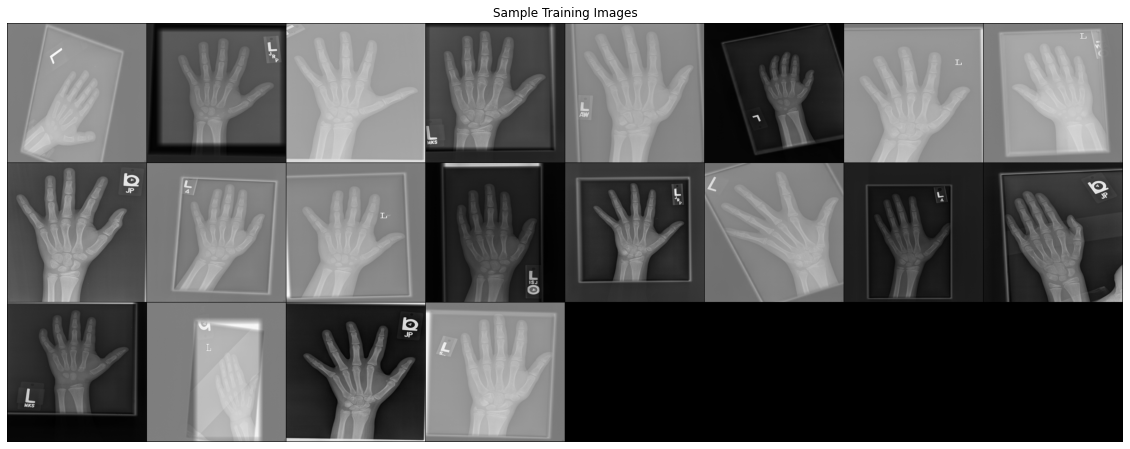

In [16]:
# Plot samples
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, utils

sample_batch = next(iter(trainig_data_loader))
plt.figure(figsize=(20, 20)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1,2,0)));

In [17]:
model = BoneAgePredictor().double().to(device)
print(model)
optimizer = optim.Adam(model.parameters())
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=2, min_lr=1e-3, verbose=True)

BoneAgePredictor(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4609, out_features=68, bias=True)
  (fc2): Linear(in_features=69, out_features=1, bias=True)
)


In [18]:
train_losses = []
val_losses = []
for epoch in range(5):
        train(model, device, trainig_data_loader, optimizer, epoch)
        train_loss = validation(model, device, trainig_data_loader,'Train')
        val_loss = validation(model, device, validation_data_loader,'Validation')
        scheduler.step(val_loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        checkpoint = torch.save({
            'epoch': epoch + 1,
            'train_loss': train_losses,
            'test_loss': val_losses,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        },'model_checkpoint.npy')

Train Epoch: 0 [0/261 (0%)]	Loss: 97.999426
Train Epoch: 0 [20/261 (7%)]	Loss: 80.946110
Train Epoch: 0 [40/261 (14%)]	Loss: 97.941118
Train Epoch: 0 [60/261 (21%)]	Loss: 63.606769
Train Epoch: 0 [80/261 (29%)]	Loss: 45.518873
Train Epoch: 0 [100/261 (36%)]	Loss: 50.116890
Train Epoch: 0 [120/261 (43%)]	Loss: 43.477017
Train Epoch: 0 [140/261 (50%)]	Loss: 53.001293
Train Epoch: 0 [160/261 (57%)]	Loss: 56.165618
Train Epoch: 0 [180/261 (64%)]	Loss: 35.348317
Train Epoch: 0 [200/261 (71%)]	Loss: 42.420494
Train Epoch: 0 [220/261 (79%)]	Loss: 27.756982
Train Epoch: 0 [240/261 (86%)]	Loss: 46.229943
Train Epoch: 0 [13/261 (93%)]	Loss: 15.477092

 Train set: Average loss: 80.9877


 Validation set: Average loss: 100.3406

Train Epoch: 1 [0/261 (0%)]	Loss: 51.240473
Train Epoch: 1 [20/261 (7%)]	Loss: 44.491033
Train Epoch: 1 [40/261 (14%)]	Loss: 43.673805
Train Epoch: 1 [60/261 (21%)]	Loss: 37.387913
Train Epoch: 1 [80/261 (29%)]	Loss: 38.333162
Train Epoch: 1 [100/261 (36%)]	Loss: 45.000095

In [19]:
checkpoint = torch.load('model_checkpoint.npy')
checkpoint

{'epoch': 5,
 'train_loss': [80.9876545448155,
  38.79762276803556,
  40.126538409275064,
  37.199995875284024,
  32.87485100521924],
 'test_loss': [100.34059170384819,
  38.754685895277035,
  46.564395991463435,
  46.873758526313786,
  37.40101658880068],
 'state_dict': OrderedDict([('conv1.weight',
               tensor([[[[-4.8261e-01, -2.4570e-01,  1.0481e-01],
                         [-6.8068e-01,  1.0030e-01,  4.0764e-01],
                         [-3.2863e-01,  3.8800e-01,  1.0520e-03]]],
               
               
                       [[[-2.1378e-02, -3.2056e-01, -4.6725e-02],
                         [ 1.2551e+00,  9.9087e-01, -4.4354e-01],
                         [ 4.1148e-01, -9.9681e-01,  3.7160e-01]]],
               
               
                       [[[ 2.7086e-02, -1.5578e+00, -9.0319e-01],
                         [ 6.9355e-01,  4.7469e-01,  1.6355e-01],
                         [-9.6387e-01, -8.0211e-01,  2.2904e-01]]],
               
               
  

In [20]:
model.load_state_dict(checkpoint['state_dict'])
model

BoneAgePredictor(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4609, out_features=68, bias=True)
  (fc2): Linear(in_features=69, out_features=1, bias=True)
)

In [21]:
optimizer.load_state_dict(checkpoint['optimizer'])
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [22]:
epoch = checkpoint['epoch']
epoch

5

In [23]:
train_loss = checkpoint['train_loss']
train_loss

[80.9876545448155,
 38.79762276803556,
 40.126538409275064,
 37.199995875284024,
 32.87485100521924]

In [24]:
test_loss = checkpoint['test_loss']
test_loss

[100.34059170384819,
 38.754685895277035,
 46.564395991463435,
 46.873758526313786,
 37.40101658880068]

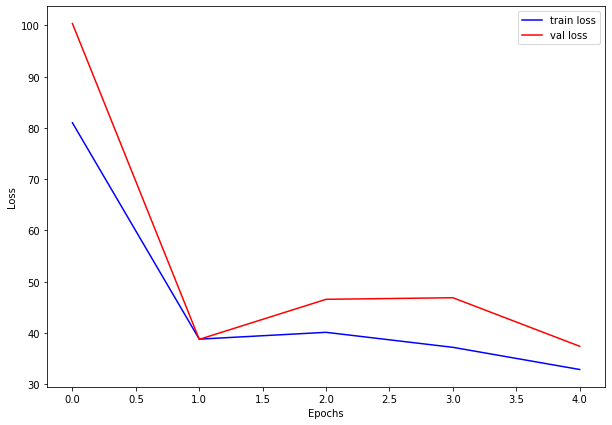

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(train_losses, color='blue', linestyle='-', label='train loss')
plt.plot(val_losses, color='red', linestyle='-', label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
!git clone https://github.com/jacobgil/pytorch-grad-cam.git

fatal: destination path 'pytorch-grad-cam' already exists and is not an empty directory.


In [27]:
cd pytorch-grad-cam

/content/pytorch-grad-cam


In [28]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [29]:
!pip install --upgrade torchcam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activation = None
        self.model.eval()
        self.hook = self.model._modules.get(target_layer).register_forward_hook(self.hook_fn)
        
    def hook_fn(self, module, input, output):
        self.activation = output.detach()
        
    def __call__(self, x):
        output = self.model(x)
        self.model.zero_grad()
        one_hot = torch.zeros_like(output, dtype=torch.float)
        one_hot[0][output.argmax()] = 1
        one_hot.requires_grad = True
        one_hot = one_hot.to(x.device)
        self.model.zero_grad()
        output.backward(gradient=one_hot)
        grads = self.activation.grad
        pooled_grads = F.adaptive_avg_pool2d(grads, 1)
        activations = self.activation
        weights = pooled_grads.view(pooled_grads.size(0), -1)
        activations = activations.view(activations.size(0), -1)
        cam = torch.matmul(weights, activations.T)
        cam = cam.view(cam.size(0), 1, 7, 7)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=(224, 224), mode='bilinear', align_corners=False)
        cam = cam.squeeze()
        cam = cam.cpu().numpy()
        return cam
        
    def remove_hook(self):
        self.hook.remove()

In [31]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = BoneAgePredictor()
model
model.eval()

# initialize Grad-CAM
target_layer = model.conv5
cam = GradCAM(model, target_layer, use_cuda)

for input, target in validation_data_loader:
    # move inputs and targets to device
    input, target = input.to(device), target.to(device)

    # generate cam
    output = model(input)
    loss = F.l1_loss(output, target)
    loss.backward()
    cam(input_tensor=input)

    # visualize cam
    heatmap = cam.generate(target_category=0)
    cam_image = cam.overlay(heatmap, input)

TypeError: ignored

In [32]:
conv5 = nn.Conv2d(128, 128, 3)
weights = conv5.state_dict()['weight']
weights

tensor([[[[-7.3147e-03, -2.4755e-02,  2.7136e-02],
          [-1.9442e-02, -2.3366e-02,  2.2240e-02],
          [-1.5243e-02,  1.5449e-04,  2.6168e-02]],

         [[ 2.8233e-02,  3.9895e-03, -5.4702e-03],
          [-1.3075e-02,  1.9692e-02,  2.8012e-02],
          [-2.7462e-02,  2.9100e-02, -2.7833e-03]],

         [[-3.9746e-03, -2.2053e-02,  2.8704e-02],
          [ 2.3694e-02, -1.2102e-02, -2.7846e-02],
          [-1.2685e-03,  2.5154e-02, -1.5936e-03]],

         ...,

         [[-2.4056e-02,  1.8407e-02, -2.3394e-02],
          [ 1.1111e-02,  5.3664e-03,  2.4073e-02],
          [-1.1086e-02,  2.1776e-02, -2.3786e-02]],

         [[-2.1699e-02,  8.7229e-03, -1.8351e-02],
          [ 7.5991e-03, -1.3259e-02, -2.0301e-02],
          [-1.9647e-02,  2.1170e-02, -4.7276e-03]],

         [[ 2.2963e-02,  1.0824e-03, -1.8291e-03],
          [-1.0315e-02, -2.4841e-02, -1.9536e-02],
          [ 2.6928e-03,  2.3628e-02,  1.2827e-02]]],


        [[[-2.9106e-02, -5.6039e-03,  2.5458e-02],
  

In [33]:
model = BoneAgePredictor()
model

BoneAgePredictor(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4609, out_features=68, bias=True)
  (fc2): Linear(in_features=69, out_features=1, bias=True)
)

In [34]:
target_layers = weights
target_layers

tensor([[[[-7.3147e-03, -2.4755e-02,  2.7136e-02],
          [-1.9442e-02, -2.3366e-02,  2.2240e-02],
          [-1.5243e-02,  1.5449e-04,  2.6168e-02]],

         [[ 2.8233e-02,  3.9895e-03, -5.4702e-03],
          [-1.3075e-02,  1.9692e-02,  2.8012e-02],
          [-2.7462e-02,  2.9100e-02, -2.7833e-03]],

         [[-3.9746e-03, -2.2053e-02,  2.8704e-02],
          [ 2.3694e-02, -1.2102e-02, -2.7846e-02],
          [-1.2685e-03,  2.5154e-02, -1.5936e-03]],

         ...,

         [[-2.4056e-02,  1.8407e-02, -2.3394e-02],
          [ 1.1111e-02,  5.3664e-03,  2.4073e-02],
          [-1.1086e-02,  2.1776e-02, -2.3786e-02]],

         [[-2.1699e-02,  8.7229e-03, -1.8351e-02],
          [ 7.5991e-03, -1.3259e-02, -2.0301e-02],
          [-1.9647e-02,  2.1170e-02, -4.7276e-03]],

         [[ 2.2963e-02,  1.0824e-03, -1.8291e-03],
          [-1.0315e-02, -2.4841e-02, -1.9536e-02],
          [ 2.6928e-03,  2.3628e-02,  1.2827e-02]]],


        [[[-2.9106e-02, -5.6039e-03,  2.5458e-02],
  

In [35]:
input_tensor = validation_data_loader
input_tensor

In [36]:
cam = GradCAM(model=model, target_layers = target_layers, use_cuda=use_cuda)
cam

TypeError: ignored

In [37]:
class GradCAM:
    def init(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activation = None
        self.gradient = None

    def save_gradient(self, grad):
        self.gradient = grad

    def forward(self, x):
        x = self.model.conv5(x)
        x = self.model.batch5(x)

        self.activation = x

        x = self.model.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.model.fc(x)

        return x

    def backward(self, output):
        one_hot = output.mean(dim=0)
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

    def generate(self):
        weights = self.gradient.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activation).sum(1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=(224, 224), mode='bilinear', align_corners=False)
        cam = cam.squeeze(1)
        cam = cam.detach().numpy()
        return cam

model = BoneAgePredictor()
target_layer= model.conv5
grad_cam = GradCAM(model, target_layer, use_cuda = use_cuda)
image = torch.randn(1, 3, 224, 224)

output = grad_cam.forward(image)
grad_cam.backward(output)
cam = grad_cam.generate()

TypeError: ignored

In [ ]:
# check = torch.rand(5,1,256,256)
# model = BoneAgePredictor();
# print(model.forward(check).size())

In [ ]:
# check = pd.read_csv(dataset_path('boneage-training-dataset.csv'));
# print(check)
# print(check['boneage'][0])
# print(check['id'][1])
# check = Image.open(dataset_path('boneage-training-dataset',str(check['id'][1])+'.png')).resize((256,256))
# print(check)
# # check = transform(check)
# # print(check.size())
# # check = torch.from_numpy(np.array(check['boneage'][0]))
# # print(check)